# Regression task - time series forecasting

Goal of this notebook is to provide predictive model of daily volumes for Yahoo S&P 500 index.

https://finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC

As a sample for development, period from 2012 to 2016 will be considered. As an out of fold testing sample, period from 2017 to 2018 will be used.

As an evaluation metric, r2 (coeficient of determination) will be cosidered, since it is at least for me more lucid than rmse, which is used for models training.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

Data from yahoo are imported through yfinance library.





In [23]:
import yfinance as yf
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np

ticker = yf.Ticker("^GSPC")
data = ticker.history(start="2011-10-01", end="2018-12-31")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from aux_functions import *
from sklearn.model_selection import KFold

Let's have a look on how does the series looks like.

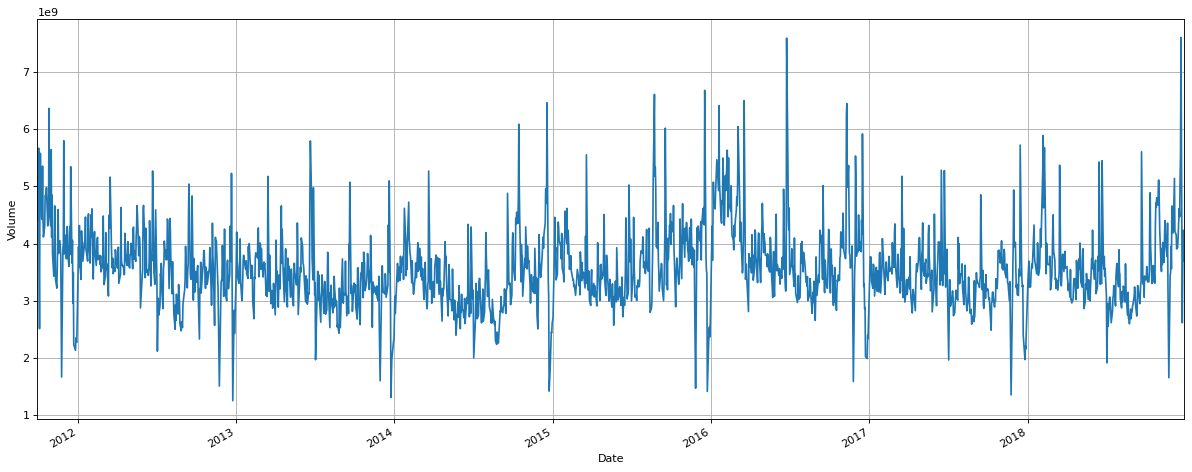

In [2]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
data['Volume'].plot()
plt.ylabel('Volume')
plt.tight_layout()
plt.grid()
plt.show()

Besides the volume, there are open, close high and low prices in the dataset that can be used for prediction of future volume as well.
Let's have a look at it.

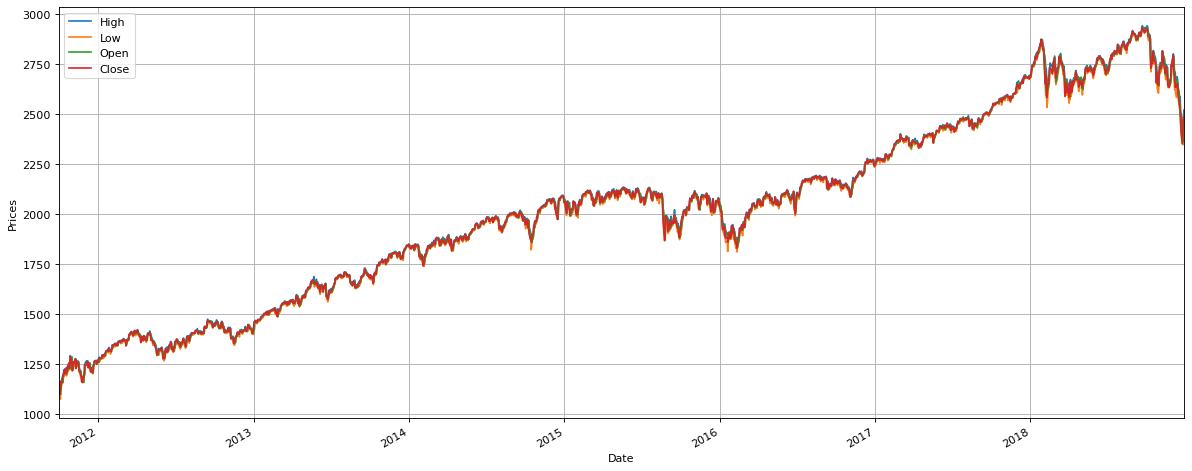

In [3]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
data['High'].plot()
data['Low'].plot()
data['Open'].plot()
data['Close'].plot()
plt.ylabel('Prices')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

#### Data sample:

In [4]:
data = data.reset_index()
data = data.sort_values(by = 'Date', ascending = False).reset_index(drop = True)

data.head(5)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,3702620000,0,0
1,2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,4096610000,0,0
2,2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,4233990000,0,0
3,2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2613930000,0,0
4,2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,7609010000,0,0


### Preparation of dataset.

Features for prediction of volume in next days that I used:

1. Volumes from previous day, previous 2 days, 3 days.
2. Mean of the volumes from previous 2, 3, 5, 7, 10, 14, 21, 30, 45 days.
3. The same features also for open, close, high, low, prices.
4. Weekday, Month features - to capture some shorttime and longtime seasonalities.
5. Ratios of features - for example ratio of volume from previous day and mean of the volumes in previous 10 days.

In [5]:
data = compute_history(data)
data = compute_fractions(data)

gc.collect()

6665

Train/test split

In [6]:
del data['Dividends']
del data['Stock Splits']


train = data.query('Date >= "2012-02-01" and Date <= "2016-01-31"').reset_index(drop = True)
test = data.query('Date >= "2017-01-01" and Date <= "2018-12-31"').reset_index(drop = True)

del data
gc.collect()

preds = list(train)
for pred in ['Date',  'Open', 'High', 'Low', 'Close', 'Volume']:
    preds.remove(pred)

6

## Explanatory Data Analysis

Let's Have a look on prediction of actual Volume with volume form previous day, mean of volumes from last three weeks and mean of volumes from last 30 days:

R-squared performance of Volume_1 on test_set:0.14505020233246946
R-squared performance of Volume_21 on test_set:0.1371510651676182
R-squared performance of Volume_30 on test_set:0.14569459021238162


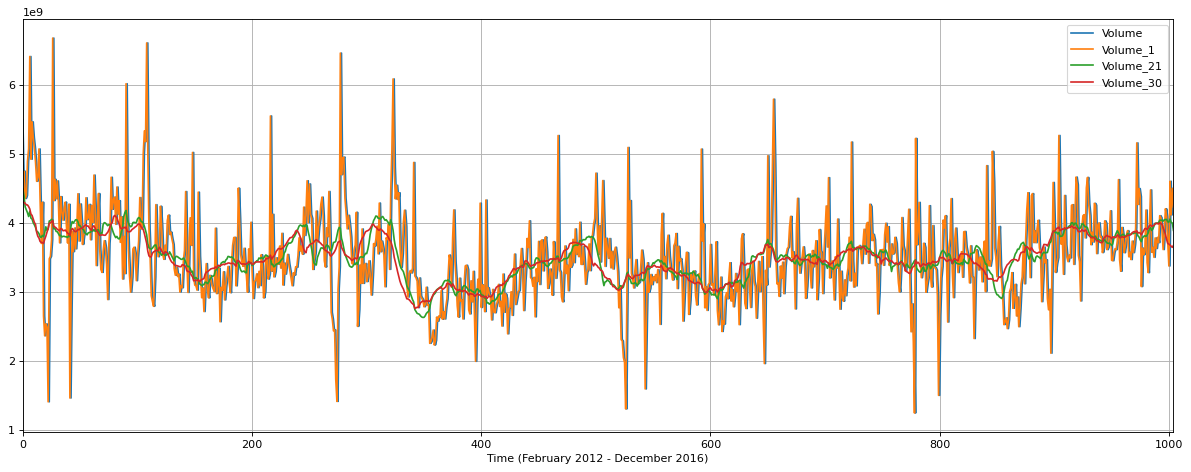

In [8]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
train['Volume'].plot()

for pred in ['Volume_1','Volume_21', 'Volume_30']:
    train[pred].plot()
    print(f"R-squared performance of {pred} on test_set:{r2_score(train['Volume'], train[pred])}")

plt.xlabel('Time (February 2012 - December 2016)')
plt.legend()
plt.tight_layout()
plt.grid()


plt.show()

It look that these predictors alone are not the best option for prediction of actual volume. But their combination could be. Mean from previous 21 and 30 days captures the trend of time series, whereas the volume from previous day copy the local spikes.

Let's have a look at month and weekday varibles:

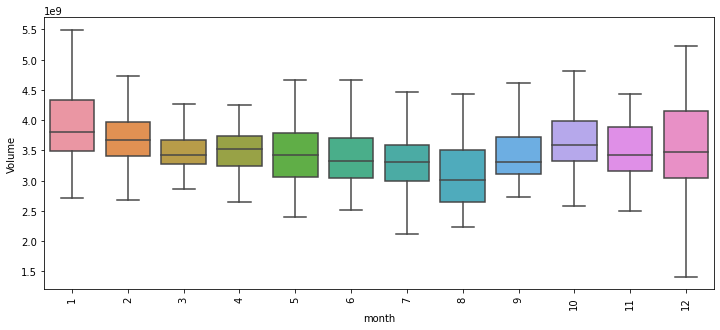

In [9]:
graph_exploration_continuous(train['month'],train['Volume'])

Box plot of the Volumes in particular months shows that the volumes are usually lower in the middle of the year and are highest around winter months.

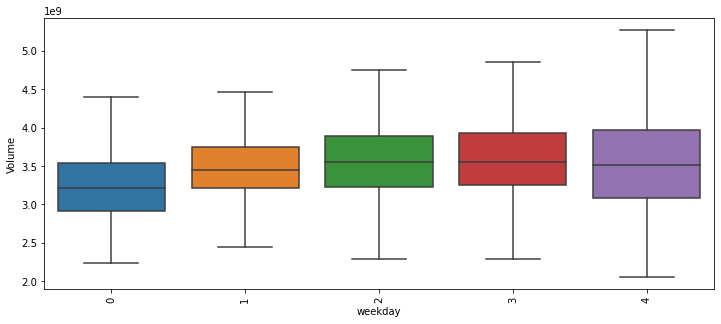

In [10]:
graph_exploration_continuous(train['weekday'],train['Volume'])

Box plot of the Volumes in particular weekdays shows that the volumes are usually lower on monday and starts to grow from tuesday.

# Building of predictive models:


Introduction of predictive models - LGBM, Random Forest

LGBM is newer implementation of famous XGBoost algorithm. Trained model is ensemble of many decision trees (usually), where every next decision tree is trained with (pseudo)residuals as a target variable from previous decion trees. Final prediction is then made as average of these decision trees.

LGBM implementation has few advantages over XGBoost - it can handle categorical variables implicitly (you do not need OHE), training of the model is much faster, etc. The results are usually pretty similar.

Fitting of decision trees requires less data preparation than for example logistic regression, where linear relationship between target and variables is demanded. For example I do not have to care about quadratic relationship between age and target, because decision trees can handle it pretty fine. Therefore I do not need to care much about data preprocessing right now (i am not saying, that is never necessary). Next big advantage of decion trees is that in a similar way as nonlinearity implicitely finds interactions between variables. In the linear models you will never find interactions, unless you will create them manually.

Disadvantage of these algorithms is that they are often harder to explain then linear models, where the whole model can be written as equation.

Random forest is in the same ensemble of independently constructed decision trees. Final prediction is consequently made as average from particular trees.



## Modelling strategy:

Data are already splitted to in-time and out of time, which would be used as unseen test set.

Take the training data and perform 5-fold cross-validation. Use validation set as the set for finetunning of parameters - number of trees in lgbm and random forest. This will result fo have 5 predictive models - one model per fold.

Take the unseen test data and score it with each of your 5 models. Take the average prediction as the final one.

In [ ]:
n_splits = 5
cross_val = KFold(n_splits= n_splits, shuffle=True, random_state = 10)

results = train_model_CV(train, test, preds,  'Volume', cross_val)


In [12]:
print(f'Average train R-squared of LGBM from 5 models: {np.mean(results[3])}')
print(f'Average valid R-squared of LGBM from 5 models: {np.mean(results[4])}')

print(f'Average train R-squared of RF from 5 models: {np.mean(results[5])}')
print(f'Average valid R-squared of RF from 5 models: {np.mean(results[6])}')

Average train R-squared of LGBM from 5 models: 0.7186115377139606
Average valid R-squared of LGBM from 5 models: 0.4682838719145071
Average train R-squared of RF from 5 models: 0.18941060192225134
Average valid R-squared of RF from 5 models: 0.21916896169855882


Variable importances:

<AxesSubplot:xlabel='Importance_gain', ylabel='Feature'>

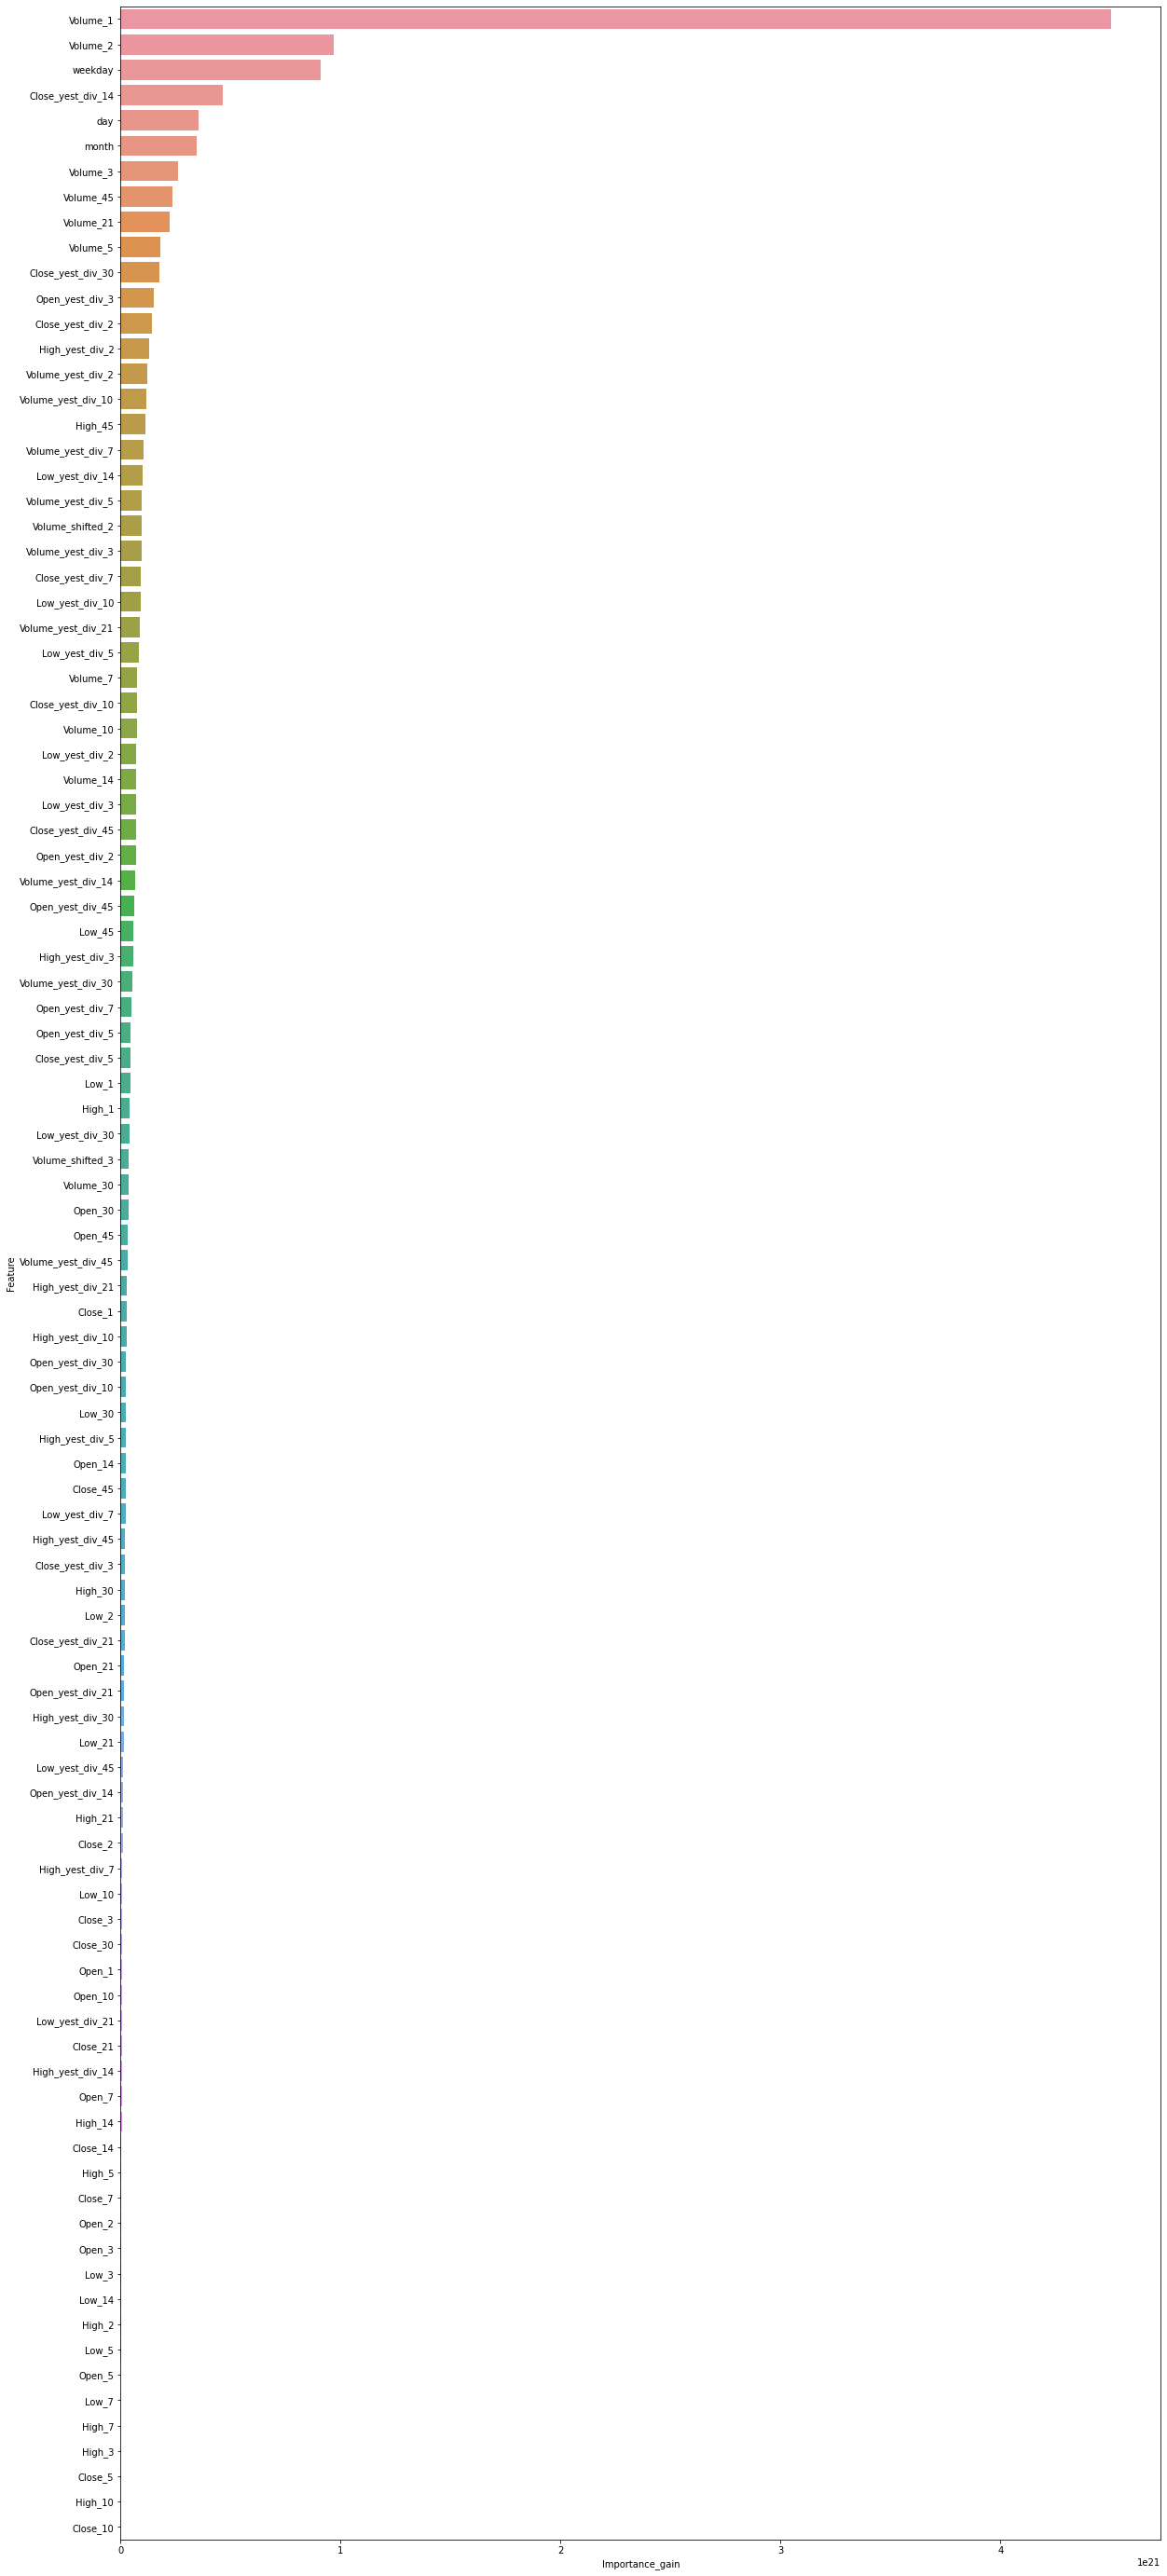

In [13]:
plt.figure(figsize = (20, len(preds)/2))
sns.barplot(x= 'Importance_gain', y='Feature', data=results[2].sort_values(by='Importance_gain', ascending= False))

It is obvious that performance of LGBM is much better than performance of Random forest. Let's score the testing out of time data with it.

In [14]:
print(f"R-squared performance o LGBM test_set:{r2_score(test['Volume'], results[0])}")

R-squared performance o LGBM test_set:0.45759858311367885


Performance of the model on test data is not so much different then the average performance on valid data is, which is good sign.

It looks that there is lot of features that are not too much used in variable importance chart. 
Let's just for sake of curiousity have a look at the model with only top 20 features:

In [ ]:
preds_new = results[2].sort_values(by = 'Importance_gain', ascending = False)['Feature'].head(20).tolist()

n_splits = 5
cross_val = KFold(n_splits= n_splits, shuffle=True, random_state = 10)


results = train_model_CV(train, test, preds_new,  'Volume' , cross_val)

In [16]:
print(f'Average train R-squared of LGBM from 5 models: {np.mean(results[3])}')
print(f'Average valid R-squared of LGBM from 5 models: {np.mean(results[4])}')

print(f'Average train R-squared of RF from 5 models: {np.mean(results[5])}')
print(f'Average valid R-squared of RF from 5 models: {np.mean(results[6])}')

Average train R-squared of LGBM from 5 models: 0.7115834370148703
Average valid R-squared of LGBM from 5 models: 0.4816974540908901
Average train R-squared of RF from 5 models: 0.14322488233087483
Average valid R-squared of RF from 5 models: 0.15271685265629473


In [17]:
print(f"R-squared performance of LGBM on test_set: {r2_score(test['Volume'], results[0])}")

R-squared performance of LGBM on test_set: 0.4729308811063616


<AxesSubplot:xlabel='Importance_gain', ylabel='Feature'>

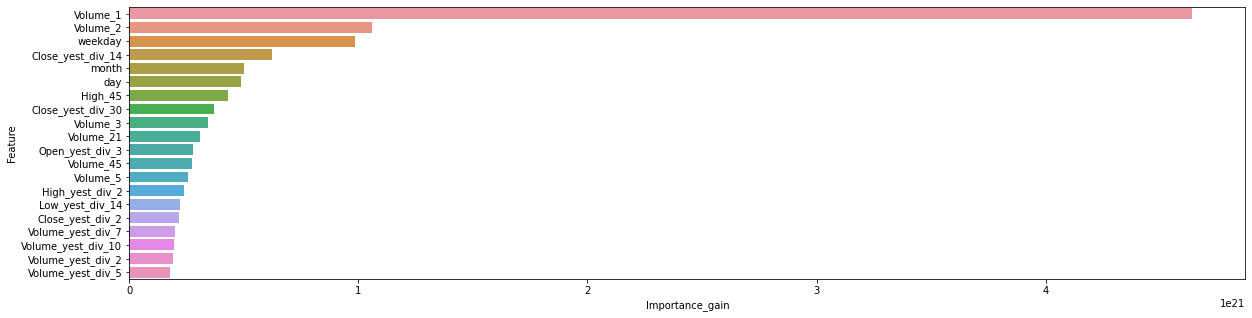

In [22]:
plt.figure(figsize = (20, 5))
sns.barplot(x= 'Importance_gain', y='Feature', data=results[2].sort_values(by='Importance_gain', ascending= False))

We are able to achieve higher performance (in terms of r-squared) with only subset of original features.

Let's finally visualise predictions of our model vs actual data:

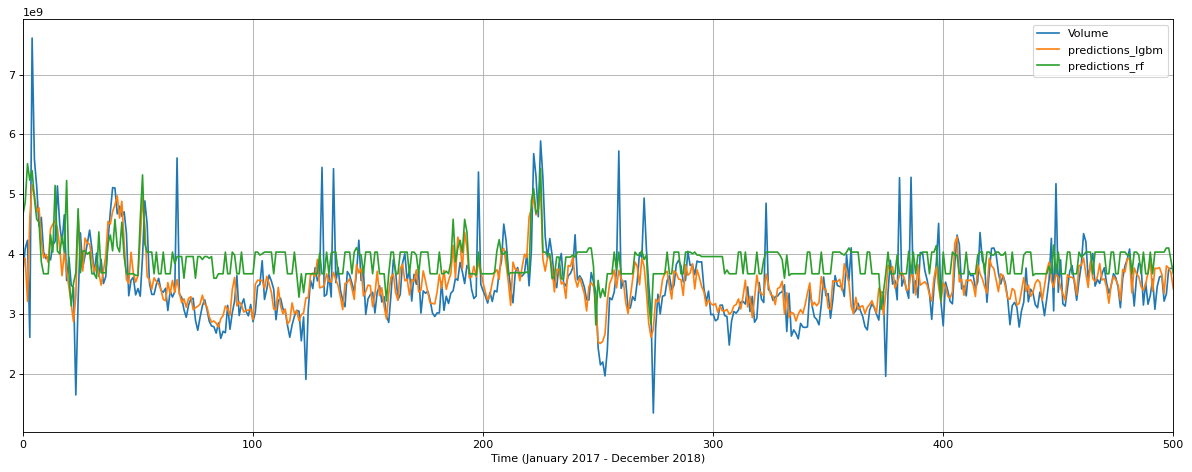

In [19]:
test['predictions_lgbm'] = results[0]
test['predictions_rf'] = results[1]

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
test['Volume'].plot()
test['predictions_lgbm'].plot()
test['predictions_rf'].plot()
plt.xlabel('Time (January 2017 - December 2018)')
plt.legend()
plt.tight_layout()
plt.grid()


plt.show()

# Conclusion 
It looks that LGBM model predicts the output data quite nicely with r-squared around 50 and improves a lot prediction by only taking a value from previous day. The thing that it does not predicts well are spikes in the data. Therefore this is the place where I see space for improvement. To label the data with spikes and develop a binary classification, that will help to predict spikes and afterward use it in the model that estimates the Volume. What could be also beneficial (and it is written in the assignment document) is to use some data outside of this calendar - at least download dates of some important days and use it as a feature. I ommited this because of lack of time. 

It is not surprise that by far the most important predictor is value of Volume from previous day, followed by averaged volume from previous two days, followed by weekday and month.

It was quite expected that random forest would perform worse. It usually not number one choice for estimation of time series. It could be fine-tuned for sure to not predict as bad results as this is, but even with exhaustive fine-tunning it probably won't beat performance of LGBM.

Other thing that can help a lot is to try reccurent neural networks, that are suitable for sequence data by design and should be tried for sure.